In [2]:
#Import dependencies
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from scipy.stats import ttest_ind

In [3]:
#Read in data
data2014_df = pd.read_csv('data/movie_data_for_past_years/2014_movies_data.csv')
data2015_df = pd.read_csv('data/movie_data_for_past_years/2015_movies_data.csv')
data2016_df = pd.read_csv('data/movie_data_for_past_years/2016_movies_data.csv')
data2017_df = pd.read_csv('data/movie_data_for_past_years/2017_movies_data.csv')
data2018_df = pd.read_csv('data/movie_data_for_past_years/2018_movies_data.csv')

In [4]:
#Create function to select relevant data columns
def yearData(df):
    return pd.DataFrame({"Title" : df['Title'],
                         "Year" : df['Year'],
                         "Genre" : df['Genre'],
                         "BoxOffice" : df['BoxOffice'],
                         "Actors" : df['Actors']})

In [5]:
#Select data to analyze
data2014_df = yearData(data2014_df)
data2015_df = yearData(data2015_df)
data2016_df = yearData(data2016_df)
data2017_df = yearData(data2017_df)
data2018_df = yearData(data2018_df)

In [6]:
#Merge data frames
mergeData = data2014_df.append(data2015_df).append(data2016_df).append(data2017_df).append(data2018_df)

In [7]:
#Split actors list
acts = mergeData["Actors"].str.split(", ", n = 6, expand = True)

acts = acts.rename(columns = {0 : 'Actor 1',
                              1 : 'Actor 2',
                              2 : 'Actor 3',
                              3 : 'Actor 4'},)
acts = acts.fillna("")

In [8]:
#Split genres list
subs = mergeData["Genre"].str.split(", ", n = 5, expand = True)

subs = subs.rename(columns = {0 : 'subgenre 1',
                              1 : 'subgenre 2',
                              2 : 'subgenre 3',
                              3 : 'subgenre 4',
                              4 : 'subgenre 5',
                              5 : 'subgenre 6'},)
subs = subs.fillna("None")


In [9]:
#Add split actor columns for main data frame
mergeData['Actor 1'] = acts['Actor 1']
mergeData['Actor 2'] = acts['Actor 2']
mergeData['Actor 3'] = acts['Actor 3']
mergeData['Actor 4'] = acts['Actor 4']


In [10]:
#Add split subgenre columns for main data frame (limiting to 3 subgenres only)
mergeData['subgenre 1'] = subs['subgenre 1']
mergeData['subgenre 2'] = subs['subgenre 2']
mergeData['subgenre 3'] = subs['subgenre 3']


In [11]:
#Drop genre and actor parent columns
mergeData = mergeData.drop(axis=1, columns=['Genre', 'Actors'])


In [12]:
#Limit range to six years
mergeData = mergeData.loc[(mergeData['Year'] == '2013') |
                          (mergeData['Year'] == '2014') |
                          (mergeData['Year'] == '2015') |
                          (mergeData['Year'] == '2016') |
                          (mergeData['Year'] == '2017') |
                          (mergeData['Year'] == '2018')]

In [13]:
#Reformat boxOffice data to float

In [14]:
mergeData['BoxOffice'] = mergeData['BoxOffice'].replace({'\$': '', ',': ''}, regex=True).astype(float)

In [15]:
#Put all actors into a list
full_act_list = mergeData['Actor 1']
full_act_list = full_act_list.append(mergeData['Actor 2']).append(mergeData['Actor 3']).append(mergeData['Actor 4'])

In [16]:
#Get list of 50 actors with most film roles during the date range
full_act_list = pd.DataFrame(full_act_list)
all_act_films = pd.DataFrame(full_act_list[0].value_counts())
all_act_films = all_act_films.drop(index='')
all_act_films = all_act_films.nlargest(50, 0)
all_act_films = all_act_films.rename(columns={0 : 'Film Count'})
all_act_films.head()

,Film Count
Liam Neeson,10
Steve Carell,9
Mark Wahlberg,9
Cate Blanchett,8
Jason Clarke,8


In [17]:
#Create function to search merge data for actors and return genre and box office data
def rad(actor):
    actor_data = pd.DataFrame(mergeData.loc[(mergeData['Actor 1'] == actor) |
                                            (mergeData['Actor 2'] == actor) | 
                                            (mergeData['Actor 3'] == actor) | 
                                            (mergeData['Actor 4'] == actor)])
    film_count = actor_data['Title'].count()
    sum_boxoffice = actor_data['BoxOffice'].sum()
    mean_boxoffice = actor_data['BoxOffice'].mean()
    #Create function to check for genre = None
    def is_none(df):
        for value in df:
            if value != 'None':
                next
            else:
                return True
                break
    #Count unique genres for actor
    genres = pd.DataFrame(list(actor_data['subgenre 1']) + list(actor_data['subgenre 2']) + list(actor_data['subgenre 3']), columns=['Genre'])
    uni_gens = pd.DataFrame(genres['Genre'].unique())[0]
    if is_none(genres['Genre']) == True:
        genre_count = uni_gens.count() - 1
    else:
        genre_count = uni_gens.count()

        
    gen_max = pd.DataFrame(genres['Genre'].value_counts())
    gen_max = gen_max.reset_index()
    if gen_max['index'][0] != "None":
        get_max = gen_max['index'][0]
    elif gen_max['index'][0] == "None":
            get_max = gen_max['index'][1]
    
    return pd.DataFrame({'Actor' : actor,
            'Film Count' : film_count, 
            'Genre Count' : genre_count,
            'Top Genre' : get_max,
            'Summed BoxOffice' : sum_boxoffice, 
            'Mean BoxOffice' : mean_boxoffice}, index = [1])
    

In [18]:
#Create empty data frame to store actor data
actor_df = pd.DataFrame(columns=['Actor',
                                 'Film Count',
                                 'Genre Count',
                                 'Top Genre',
                                 'Summed BoxOffice',
                                 'Mean BoxOffice'])

In [19]:
#Build actor data frame
act_list = all_act_films.reset_index()
act_list = list(act_list['index'])
for actor in act_list:
    results = rad(actor)
    actor_df = actor_df.append(results, ignore_index=True)

In [20]:
#Change count data to float type
actor_df['Film Count'] = actor_df['Film Count'].astype(float)
actor_df['Genre Count'] = actor_df['Genre Count'].astype(float)

In [21]:
#Create function to pull full list of genres only from actors being investigated
def rush(actor):
    actor_data = pd.DataFrame(mergeData.loc[(mergeData['Actor 1'] == actor) |
                                            (mergeData['Actor 2'] == actor) | 
                                            (mergeData['Actor 3'] == actor) | 
                                            (mergeData['Actor 4'] == actor)])

    #Count unique genres for actor
    genres = pd.DataFrame(list(actor_data['subgenre 1']) + list(actor_data['subgenre 2']) + list(actor_data['subgenre 3']), columns=['Genre'])
    uni_gens = pd.DataFrame(genres['Genre'].unique())[0]

    
    return list(uni_gens)


In [22]:
#Create clean genre list for 50 actors being evaluated
sublist = []
for actor in act_list:
    results = rush(actor)
    sublist = sublist + results
    
sublist2 = pd.DataFrame(sublist)
sublist2 = pd.DataFrame(sublist2[0].unique())
sublist2 = sublist2.drop(index=10)
sublist2 = sublist2.rename(columns={0 : 'Genres'})
sublist2 = sublist2.sort_values('Genres')
genre_list = list(sublist2['Genres'])
genre_list = pd.DataFrame(genre_list)
genre_list = genre_list.rename(columns={0 : 'Genres'})
genre_list = genre_list.reindex()

# Film Genre Diversity by Actor

Here we look at 50 actors who performed in 5 or more films from 2013 to 2018 to evaluate diversity of roles based on film genre, which may be a measure of "type casting." The purpose of this analysis is to determine if the data reveals any differences in genre mobility among actors and to see if the data suggests that genre mobility is beneficial or neutral to boxoffice returns, or if the practice of type casting, or an actor chosing to "stay in their lane," results in better returns.   

Movie data from the years 2013 through 2018 were pulled from the Open Movie Database (OMDB) for use in this analysis. For each film in the data set, the first 3 genre keywords listed for each film were used in the assessment. Not all films had 3 genre keywords listed; however, if more than one keyword was present, they were weighted equally (e.g., the first genre keyword was not given priority over the second or third). There were 21 categories of genre keywords included in the 50-actor data set. The genre keywords were as follows:


In [23]:
genre_list

,Genres
0,Action
1,Adventure
2,Animation
3,Biography
4,Comedy
5,Crime
6,Documentary
7,Drama
8,Family
9,Fantasy


# Genre Frequency

For the 50 actors analyzed, the genres of drama, comedy, action, and adventure topped the list as most frequently sited (Figure 1), which was not surprising. Biography held the fifth place spot, which was an interesting finding.

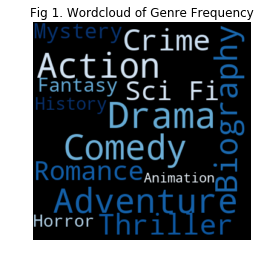

In [24]:
# Create a word cloud of the most commonly sited genres for the 50 actor data set
wordcloud_list = []
for actor in act_list:
    results = rush(actor)
    wordcloud_list = wordcloud_list + results
    
wordcloud_list2 = pd.DataFrame(wordcloud_list)
wordcloud_list2 = pd.DataFrame(wordcloud_list2.loc[wordcloud_list2[0] != 'None'])
word_list = wordcloud_list2[0]
word_list = list(word_list)
str1 = ' '.join(str(e) for e in word_list)
str1

text = str1

# Create the wordcloud object
wordcloud = WordCloud(width=5*72, 
                      height=5*72, 
                      margin=0, 
                      max_font_size=60, 
                      min_font_size=20, 
                      background_color="black", 
                      colormap="Blues").generate(text)
 
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title("Fig 1. Wordcloud of Genre Frequency")
plt.savefig("wordcloud.pdf")
plt.show()

In [25]:
wordcloud_list2[0].value_counts()

Drama          47
Action         42
Comedy         42
Adventure      40
Biography      33
Crime          30
Thriller       27
Romance        24
Sci-Fi         24
Mystery        20
Fantasy        17
History        15
Horror         14
Animation      12
Music           8
Family          7
War             6
Sport           6
Western         3
Documentary     3
Musical         2
Name: 0, dtype: int64

# Genre Score

Genre mobility was assessed by determining the number of films each actor performed in during the analysis period and quantifying the unique genre keywords associated with those films. A higher genre count was associated with participation in more diverse film types, while a lower count was associated with a narrower range. A genre score was derived by subtracting the film count from the genre count and then normalizing the resulting value to the difference in genre/film count means. The resulting score was intended to quantify an individual actor's genre mobility compared to the group as a whole.

In [26]:
#Create a genres score and add to data frame
mean_film_count = actor_df['Film Count'].mean()
mean_genre_count = actor_df['Genre Count'].mean()
actor_df['Genre Score'] = ((actor_df['Genre Count'] - actor_df['Film Count'])/(mean_genre_count - mean_film_count)).astype(float)
# Recast box office totals in thousands of dollars for ease of processing
actor_df['Summed BoxOffice'] = actor_df['Summed BoxOffice']/1000
actor_df['Mean BoxOffice'] = actor_df['Mean BoxOffice']/1000
actor_df = actor_df.rename(columns={'Summed BoxOffice' : 'BoxOffice Sum (K)', 
                                    'Mean BoxOffice' : 'Mean BoxOffice/Film (K)'})
actor_df.head()

,Actor,Film Count,Genre Count,Top Genre,BoxOffice Sum (K),Mean BoxOffice/Film (K),Genre Score
0,Liam Neeson,10.0,11.0,Drama,154221.811,38555.452750,0.485437
1,Steve Carell,9.0,10.0,Drama,343656.270,68731.254000,0.485437
2,Mark Wahlberg,9.0,8.0,Comedy,542716.709,90452.784833,-0.485437
3,Cate Blanchett,8.0,10.0,Drama,722701.565,120450.260833,0.970874
4,Jason Clarke,8.0,10.0,Drama,329976.759,82494.189750,0.970874


# Distribution

First, we wanted to develop an understanding of the distribution. Our initial assumption was that more performances would correspond to higher genre counts, so we looked at the distribution of actors to performances and the distribution of genre keywords versus performance counts. In our sample, the majority of actors (44 out of 50) performed in 5 to 7 films during the study period with only 6 actors performing in 8 or more films (Figure 2). As expected, film genre diversity generally increased with the number of performances (Figure 3). A histagram of genre scores shows that genre mobility across the data set was generally normally distributed (Figure 4).

In [27]:
#Calculate actor counts and mean genre keywords by film count
actor_count = pd.DataFrame(actor_df.groupby('Film Count')['Actor'].count())
actor_count['Avg Genre Tags'] = pd.DataFrame(actor_df.groupby('Film Count')['Genre Count'].mean())
actor_count

,Actor,Avg Genre Tags
Film Count,,
5.0,9,7.555556
6.0,23,8.000000
7.0,12,9.166667
8.0,3,10.333333
9.0,2,9.000000
10.0,1,11.000000


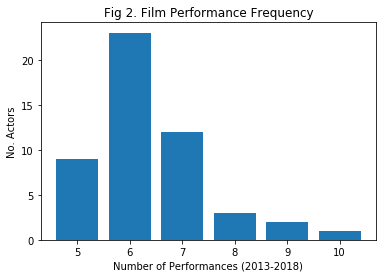

In [28]:
#Plot Film Performance Frequency
plt.bar(actor_count.index.values, actor_count['Actor'])
plt.xlabel("Number of Performances (2013-2018)")
plt.ylabel("No. Actors")
plt.title("Fig 2. Film Performance Frequency")
plt.savefig("performance_frequency_bar.png")
plt.show()

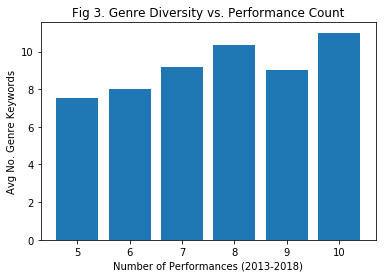

In [29]:
#Plot Genre Diversity vs. Performance Count
plt.bar(actor_count.index.values, actor_count['Avg Genre Tags'])
plt.xlabel("Number of Performances (2013-2018)")
plt.ylabel("Avg No. Genre Keywords")
plt.title("Fig 3. Genre Diversity vs. Performance Count")
plt.savefig("genre_div_vs_count-bar.png")
plt.show()

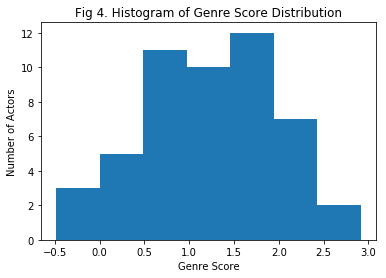

In [30]:
# Plot Histogram of Genre Score Distribution
plt.hist(actor_df['Genre Score'], bins=7)
plt.ylabel("Number of Actors")
plt.xlabel("Genre Score")
plt.title("Fig 4. Histogram of Genre Score Distribution")
plt.savefig("histo_genre_score.png")
plt.show()

# Ranking by Genre Count and Score

Next, we looked at rankings of genre mobility for the top 10 and bottom 10 actors based on genre counts and genre scores. The top 10 actors by genre count had drama as their primary listed genre (Figure 5). The bottom 10 actors by genre count had adventure as their primary listed genre followed by action and comedy (Figure 6). When assessed by genre score, the top 10 actors had the same primary genre (drama) (Figure 7); whereas, the bottom 10 actors had comedy as the primary genre (Figure 8). These results suggest that actors known for dramatic roles have generally higher genre mobility and are more likely to be cast in diverse film types than actors known for comedies or action/adventure films.


In [31]:
# Get top and bottom 10 actors by Genre Count
largeGen = pd.DataFrame(actor_df.nlargest(10, "Genre Count"))
smallGen = pd.DataFrame(actor_df.nsmallest(10, "Genre Count"))

In [32]:
gen_count_df = largeGen.append(smallGen).sort_values('Genre Count', ascending=False)

In [33]:
gen_count_df

,Actor,Film Count,Genre Count,Top Genre,BoxOffice Sum (K),Mean BoxOffice/Film (K),Genre Score
13,Michael Fassbender,7.0,13.0,Drama,294840.756,49140.126000,2.912621
5,Domhnall Gleeson,8.0,11.0,Drama,226305.089,45261.017800,1.456311
9,Emily Blunt,7.0,11.0,Adventure,188643.327,62881.109000,1.941748
0,Liam Neeson,10.0,11.0,Drama,154221.811,38555.452750,0.485437
1,Steve Carell,9.0,10.0,Drama,343656.270,68731.254000,0.485437
3,Cate Blanchett,8.0,10.0,Drama,722701.565,120450.260833,0.970874
4,Jason Clarke,8.0,10.0,Drama,329976.759,82494.189750,0.970874
7,Joel Edgerton,7.0,10.0,Drama,112832.566,28208.141500,1.456311
12,Elle Fanning,7.0,10.0,Drama,223277.782,55819.445500,1.456311
14,Ryan Reynolds,7.0,10.0,Sci-Fi,135510.718,33877.679500,1.456311


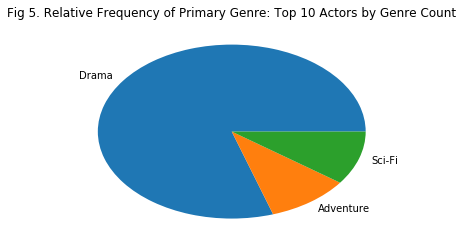

In [34]:
#Plot Relative Frequency of Primary Genre: Top 10 Actors by Genre Count
labels = largeGen['Top Genre'].unique()
plt.pie(largeGen['Top Genre'].value_counts(), labels=labels)
plt.title("Fig 5. Relative Frequency of Primary Genre: Top 10 Actors by Genre Count")
plt.savefig("top10_by_genre_count_pie.png")
plt.show()

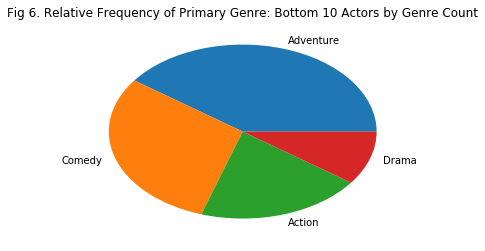

In [35]:
#Plot Relative Frequency of Primary Genre: Bottom 10 Actors by Genre Count
labelsS = smallGen['Top Genre'].unique()
plt.pie(smallGen['Top Genre'].value_counts(), labels=labelsS)
plt.title("Fig 6. Relative Frequency of Primary Genre: Bottom 10 Actors by Genre Count")
plt.savefig("low10_by_genre_count_pie.png")
plt.show()

In [36]:
# Get top and bottom 10 actors by Genre Score
large = pd.DataFrame(actor_df.nlargest(10, 'Genre Score'))
small = pd.DataFrame(actor_df.nsmallest(10, 'Genre Score'))
gen_score_df = large.append(small).sort_values('Genre Score', ascending=False)

In [37]:
gen_score_df

,Actor,Film Count,Genre Count,Top Genre,BoxOffice Sum (K),Mean BoxOffice/Film (K),Genre Score
13,Michael Fassbender,7.0,13.0,Drama,294840.756,49140.126000,2.912621
49,Johnny Depp,5.0,10.0,Adventure,251185.622,62796.405500,2.427184
9,Emily Blunt,7.0,11.0,Adventure,188643.327,62881.109000,1.941748
29,Alicia Vikander,6.0,10.0,Drama,74497.944,18624.486000,1.941748
33,Jon Hamm,6.0,10.0,Drama,385740.336,192870.168000,1.941748
36,Nicole Kidman,6.0,10.0,Drama,10542.504,10542.504000,1.941748
37,Chris Hemsworth,6.0,10.0,Action,1433803.148,286760.629600,1.941748
45,Olivia Cooke,5.0,9.0,Sci-Fi,43916.212,21958.106000,1.941748
48,Michelle Williams,5.0,9.0,Drama,186074.200,62024.733333,1.941748
5,Domhnall Gleeson,8.0,11.0,Drama,226305.089,45261.017800,1.456311


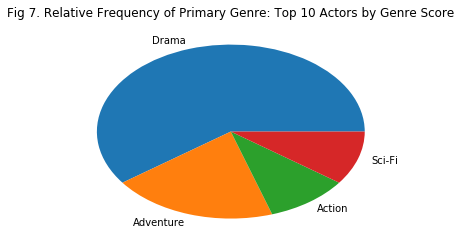

In [38]:
#Plot Relative Frequency of Primary Genre: Top 10 Actors by Genre Score
labelsLg = large['Top Genre'].unique()
plt.pie(large['Top Genre'].value_counts(), labels=labelsLg)
plt.title("Fig 7. Relative Frequency of Primary Genre: Top 10 Actors by Genre Score")
plt.savefig("top10_by_genre_score_pie.png")
plt.show()

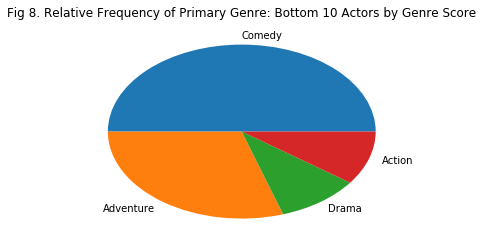

In [39]:
#Plot Relative Frequency of Primary Genre: Bottom 10 Actors by Genre Score
labelsSm = small['Top Genre'].unique()
plt.pie(small['Top Genre'].value_counts(), labels=labelsSm)
plt.title("Fig 8. Relative Frequency of Primary Genre: Bottom 10 Actors by Genre Score")
plt.savefig("low10_by_genre_score_pie.png")
plt.show()

# Genre Mobility and Box Office

Next we looked at how genre mobility affected box office returns. To assess this, we compared the mean box office returns (per film) for the top and bottom 10 actors based on genre score. Average box office per film was statistically significantly greater (pvalue=0.000) for actors that were highly genre mobile as compared to those with low genre mobility.

In [40]:
#Get mean and SE box office for top 10 actors by genre score
top10 = pd.DataFrame(gen_score_df['Mean BoxOffice/Film (K)'].nlargest(10))
top10_mean = top10['Mean BoxOffice/Film (K)'].mean()
top10_ste = top10['Mean BoxOffice/Film (K)'].std()/(top10['Mean BoxOffice/Film (K)'].count() -1)


In [41]:
#Get mean and SE box office for bottom 10 actors by genre score
low10 = pd.DataFrame(gen_score_df['Mean BoxOffice/Film (K)'].nsmallest(10))
low10_mean = low10['Mean BoxOffice/Film (K)'].mean()
low10_ste = low10['Mean BoxOffice/Film (K)'].std()/(low10['Mean BoxOffice/Film (K)'].count() -1)


In [42]:
#Put results in data frame
mean_gen_scr_df = pd.DataFrame([[top10_mean, top10_ste], [low10_mean, low10_ste]], 
                               index=['Top 10', 'Bottom 10'],columns=['Mean BoxOffice', "SE"])
mean_gen_scr_df

,Mean BoxOffice,SE
Top 10,139458.654903,9120.358598
Bottom 10,35280.734072,2272.151163


In [43]:
#Run statistical comparison between groups
t10 = list(top10['Mean BoxOffice/Film (K)'])
l10 = list(low10['Mean BoxOffice/Film (K)'])

In [44]:
ttest_ind(t10, l10)

Ttest_indResult(statistic=3.894445231332718, pvalue=0.0010624875121458491)

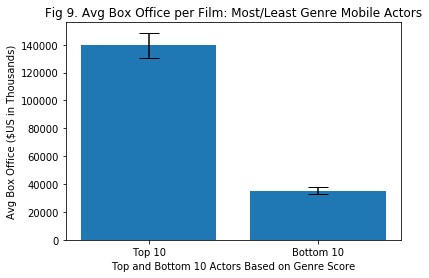

In [45]:
#Plot mean Box Office for Most/Least Genre Mobile Actors
plt.bar(mean_gen_scr_df.index.values, mean_gen_scr_df['Mean BoxOffice'], yerr=mean_gen_scr_df['SE'], capsize=10)
plt.ylabel("Avg Box Office ($US in Thousands)")
plt.xlabel("Top and Bottom 10 Actors Based on Genre Score")
plt.title("Fig 9. Avg Box Office per Film: Most/Least Genre Mobile Actors")
plt.savefig("top_bot_boxoffice_bar.png")
plt.show()

# What's Up With Comedy?

From earlier assessments, it was clear that actors with predominantly comedic credit tended to be less genre mobile than those with primarily dramatic credits. Singling out these primarily comedic actors, we can see that higher average box office receipts for primarily comedic actors generally correspond to lower genre mobility scores and vice versa (Figure 10). This could be an indication that for comedic actors, it is more profitable to be genre static, or it could show that type casting is more of a problem with comedic actors than with dramatic actors.

In [46]:
comedians = actor_df.loc[actor_df['Top Genre'] == 'Comedy']
comedians

,Actor,Film Count,Genre Count,Top Genre,BoxOffice Sum (K),Mean BoxOffice/Film (K),Genre Score
2,Mark Wahlberg,9.0,8.0,Comedy,542716.709,90452.784833,-0.485437
8,Kevin Hart,7.0,6.0,Comedy,616949.259,154237.314750,-0.485437
15,Anna Kendrick,7.0,7.0,Comedy,365340.509,73068.101800,0.000000
17,Channing Tatum,7.0,10.0,Comedy,235469.948,58867.487000,1.456311
25,Jason Bateman,6.0,7.0,Comedy,133268.161,33317.040250,0.485437
31,Tessa Thompson,6.0,7.0,Comedy,81345.235,40672.617500,0.485437
34,Ed Helms,6.0,9.0,Comedy,130961.638,43653.879333,1.456311
38,Melissa McCarthy,6.0,6.0,Comedy,174402.724,58134.241333,0.000000
43,Seth Rogen,5.0,5.0,Comedy,182683.878,45670.969500,0.000000


In [47]:
comedy_score_abs = pd.DataFrame(comedians['Genre Score'].abs())

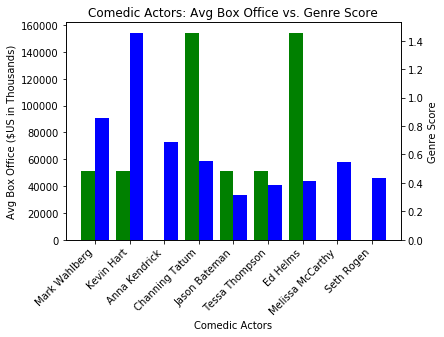

In [48]:
ax1 = plt.subplot()
ax2 = ax1.twinx()
x = comedians['Actor']
y = comedians['Mean BoxOffice/Film (K)']
z = comedy_score_abs['Genre Score']

ax1.bar(x, y,width=0.4, color='b',align='edge')
ax2.bar(x, z,width=-0.4,color='g',align='edge')
ax1.set_xticklabels(labels=x, rotation=45, ha='right')
ax1.set_ylabel("Avg Box Office ($US in Thousands)")
ax2.set_ylabel("Genre Score")
ax1.set_xlabel("Comedic Actors")
ax1.set_title("Comedic Actors: Avg Box Office vs. Genre Score")
plt.savefig("comedic_actors.png")
plt.show()

# Conclusions

In conclusion, this analysis suggests that genre mobility is more prevalent among actors with primarily dramatic film roles as compared to those with primarily comedic roles. This could be the result of type casting or studio pressure to keep comedians in their lane, where they generate more profits, or it could be a result of comedians chosing to focus on these roles. Actors with the most genre diverse roles had statistically significantly increased mean box office returns compared to the least genre mobile actors, which also suggests that an actors box office draw (i.e., star power) plays a role in their ability to successfully move between genre types. Further investigation should include better means of quantifying genre mobility, longer timeframes, regression analysis to determine correlations, and incorporation of film ratings to determine if awards and acknowledgements affect genre mobility. Additionally, weighting the genre classifications and analyzing whether the actor had a leading or supporting role in the film could enhance the analysis.